In [ ]:
import sys
import os
import json
from pathlib import Path
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

# Add src to path for visualization module
project_root = Path(os.getcwd()).parent.parent
sys.path.insert(0, str(project_root))

from src.visualization import (
    visualize_simulation,
    plot_rod_pattern,
    plot_field,
    plot_permittivity,
    EPS_CMAP,
)
from src.simulation import (
    rods_to_permittivity,
    add_source_waveguide,
    add_receiver_waveguide,
    run_simulation,
    measure_power_at_receiver,
)
from src.constants import RECEIVERS

print(f"Project root: {project_root}")

Project root: /Users/sze/project-lorentz/cs229-beam-steering


## Load All Top-K Results

Scan all checkpoint directories and collect the top configurations.

In [2]:
def find_all_results(base_dirs):
    """
    Find all top-k results from multiple output directories.
    
    Returns a list of dicts with rank, reward, iteration, rho array, and metadata.
    """
    all_results = []
    
    for base_dir in base_dirs:
        base_path = Path(base_dir)
        if not base_path.exists():
            print(f"Warning: {base_dir} does not exist")
            continue
            
        # Find all run directories
        for run_dir in sorted(base_path.iterdir()):
            if not run_dir.is_dir():
                continue
                
            # Find all checkpoints
            checkpoints = sorted(run_dir.glob("checkpoint_*"))
            if not checkpoints:
                continue
                
            # Use the latest checkpoint
            latest_checkpoint = checkpoints[-1]
            
            # Load top_k_summary
            summary_path = latest_checkpoint / "top_k_summary.json"
            if not summary_path.exists():
                continue
                
            with open(summary_path) as f:
                summary = json.load(f)
            
            # Load metadata
            metadata_path = latest_checkpoint / "metadata.json"
            metadata = {}
            if metadata_path.exists():
                with open(metadata_path) as f:
                    metadata = json.load(f)
            
            # Load each top-k config
            for entry in summary:
                rank = entry['rank']
                rho_path = latest_checkpoint / "top_k_configs" / f"rank_{rank:02d}_rho.npy"
                
                if rho_path.exists():
                    rho = np.load(rho_path)
                    all_results.append({
                        'rank': rank,
                        'reward': entry['reward'],
                        'iteration': entry['iteration'],
                        'rho': rho,
                        'rho_mean': entry.get('rho_mean'),
                        'run_dir': run_dir.name,
                        'checkpoint': latest_checkpoint.name,
                        'target_angle': metadata.get('target_angle', 90),
                        'source': str(base_dir),
                    })
    
    return all_results


# Define output directories to scan
output_dirs = [
    project_root / "results" / "aws_outputs",
    project_root / "results" / "es_outputs",
    project_root / "es_outputs",
]

all_results = find_all_results(output_dirs)
print(f"Found {len(all_results)} total configurations")

Found 4 total configurations


In [3]:
# Sort by reward (higher/less negative is better) and get top 10
all_results_sorted = sorted(all_results, key=lambda x: x['reward'], reverse=True)
top_10 = all_results_sorted[:10]

print("Top 10 Results (by reward):")
print("=" * 80)
for i, result in enumerate(top_10):
    print(f"{i+1:2d}. Reward: {result['reward']:12.2f} | "
          f"Run: {result['run_dir']} | "
          f"Iter: {result['iteration']} | "
          f"ρ_mean: {result['rho_mean']:.3f}")

Top 10 Results (by reward):
 1. Reward:      -297.60 | Run: 90deg_20251214_084750 | Iter: 1 | ρ_mean: 0.572
 2. Reward:      -524.01 | Run: 90deg_20251214_084750 | Iter: 0 | ρ_mean: 0.571
 3. Reward:    -46908.06 | Run: 90deg_20251213_234422 | Iter: 1 | ρ_mean: 0.475
 4. Reward:    -51623.32 | Run: 90deg_20251213_234422 | Iter: 0 | ρ_mean: 0.474


## Visualize Top 10 Rod Patterns

Display the 8×8 rod configurations for each of the top results.

/var/folders/4q/yqrpb58x2wn8kyw39vlnn7d00000gn/T/ipykernel_47709/4294284305.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


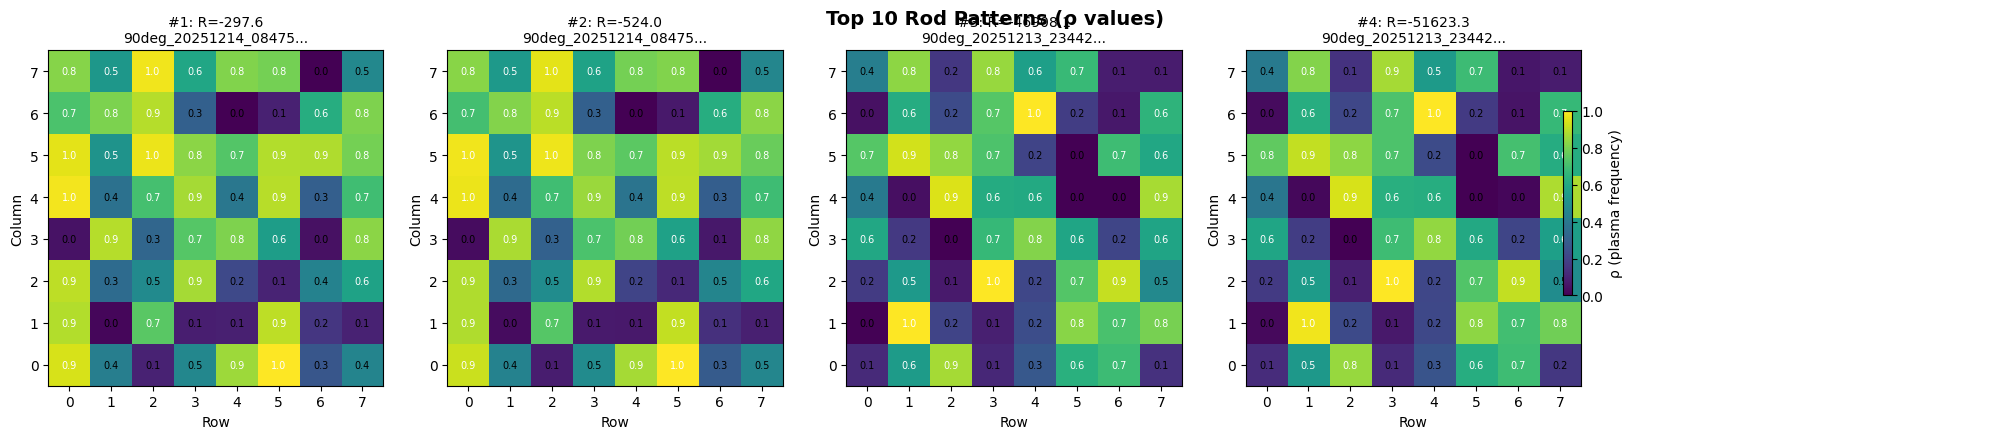

In [4]:
# Plot rod patterns for top 10
n_results = min(10, len(top_10))
n_cols = 5
n_rows = (n_results + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten() if n_results > 1 else [axes]

for idx, result in enumerate(top_10[:n_results]):
    ax = axes[idx]
    rho = result['rho']
    
    im = ax.imshow(rho.T, origin='lower', cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f"#{idx+1}: R={result['reward']:.1f}\n{result['run_dir'][:20]}...", fontsize=10)
    ax.set_xlabel('Row')
    ax.set_ylabel('Column')
    
    # Add text annotations for small grids
    if rho.shape[0] <= 8:
        for i in range(rho.shape[0]):
            for j in range(rho.shape[1]):
                val = rho[i, j]
                color = 'white' if val > 0.5 else 'black'
                ax.text(i, j, f'{val:.1f}', ha='center', va='center', 
                       color=color, fontsize=7)

# Hide unused axes
for idx in range(n_results, len(axes)):
    axes[idx].axis('off')

fig.colorbar(im, ax=axes, shrink=0.6, label='ρ (plasma frequency)')
plt.suptitle('Top 10 Rod Patterns (ρ values)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Run Simulations and Visualize Fields

Re-simulate the top configurations to show the electric field and power distribution.

Simulating best result (Reward: -297.60)...
--- Simulation ---
  Input wave frequency: f = 6.00 GHz, λ = 5.00 cm
  Grid: 400×400, resolution = 25 pts/a, dl = 0.84 mm


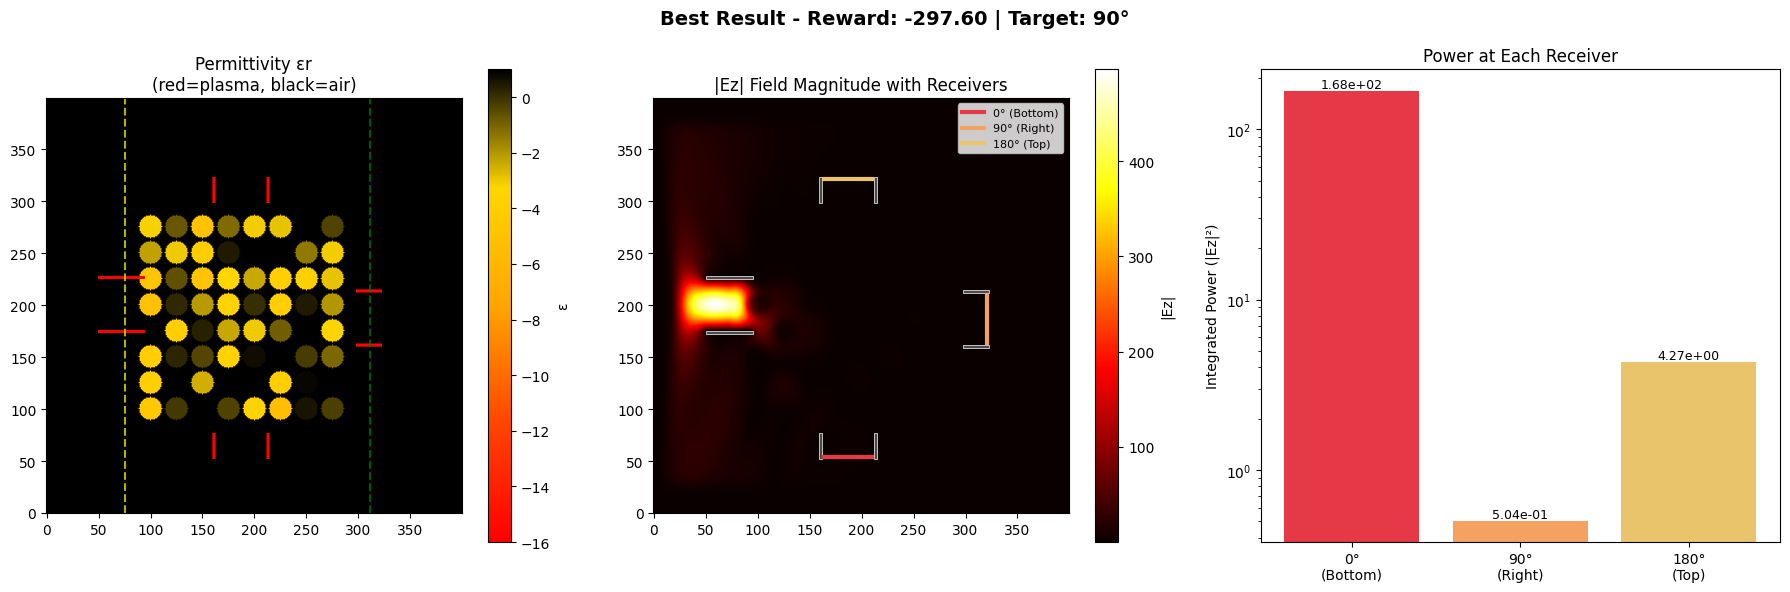

In [5]:
def simulate_from_rho(rho, verbose=False):
    """
    Full simulation pipeline: rho → eps_r → Ez → powers
    
    Args:
        rho: 8×8 array of normalized plasma frequencies [0, 1]
        verbose: Print simulation info
    
    Returns:
        eps_r: Full permittivity grid (Nx × Ny)
        Ez: Electric field (Nx × Ny complex)
        powers: Dict of {angle: power} for all receivers
    """
    # 1. Convert rod states to permittivity map
    eps_r = rods_to_permittivity(rho)
    
    # 2. Add source waveguide
    eps_r = add_source_waveguide(eps_r)
    
    # 3. Add all receiver waveguides
    for angle in RECEIVERS.keys():
        eps_r = add_receiver_waveguide(eps_r, angle)
    
    # 4. Run FDFD simulation
    Ez = run_simulation(eps_r, verbose=verbose)
    
    # 5. Measure power at all receivers
    powers = {}
    for angle in RECEIVERS.keys():
        powers[angle] = measure_power_at_receiver(Ez, angle)
    
    return eps_r, Ez, powers


# Re-simulate and visualize the best result
if len(top_10) > 0:
    best_result = top_10[0]
    print(f"Simulating best result (Reward: {best_result['reward']:.2f})...")
    
    eps_r, Ez, powers = simulate_from_rho(best_result['rho'], verbose=True)
    
    fig = visualize_simulation(
        eps_r, Ez, powers,
        title=f"Best Result - Reward: {best_result['reward']:.2f} | Target: {best_result['target_angle']}°"
    )
else:
    print("No results found to simulate.")

Simulating #1...
Simulating #2...
Simulating #3...
Simulating #4...


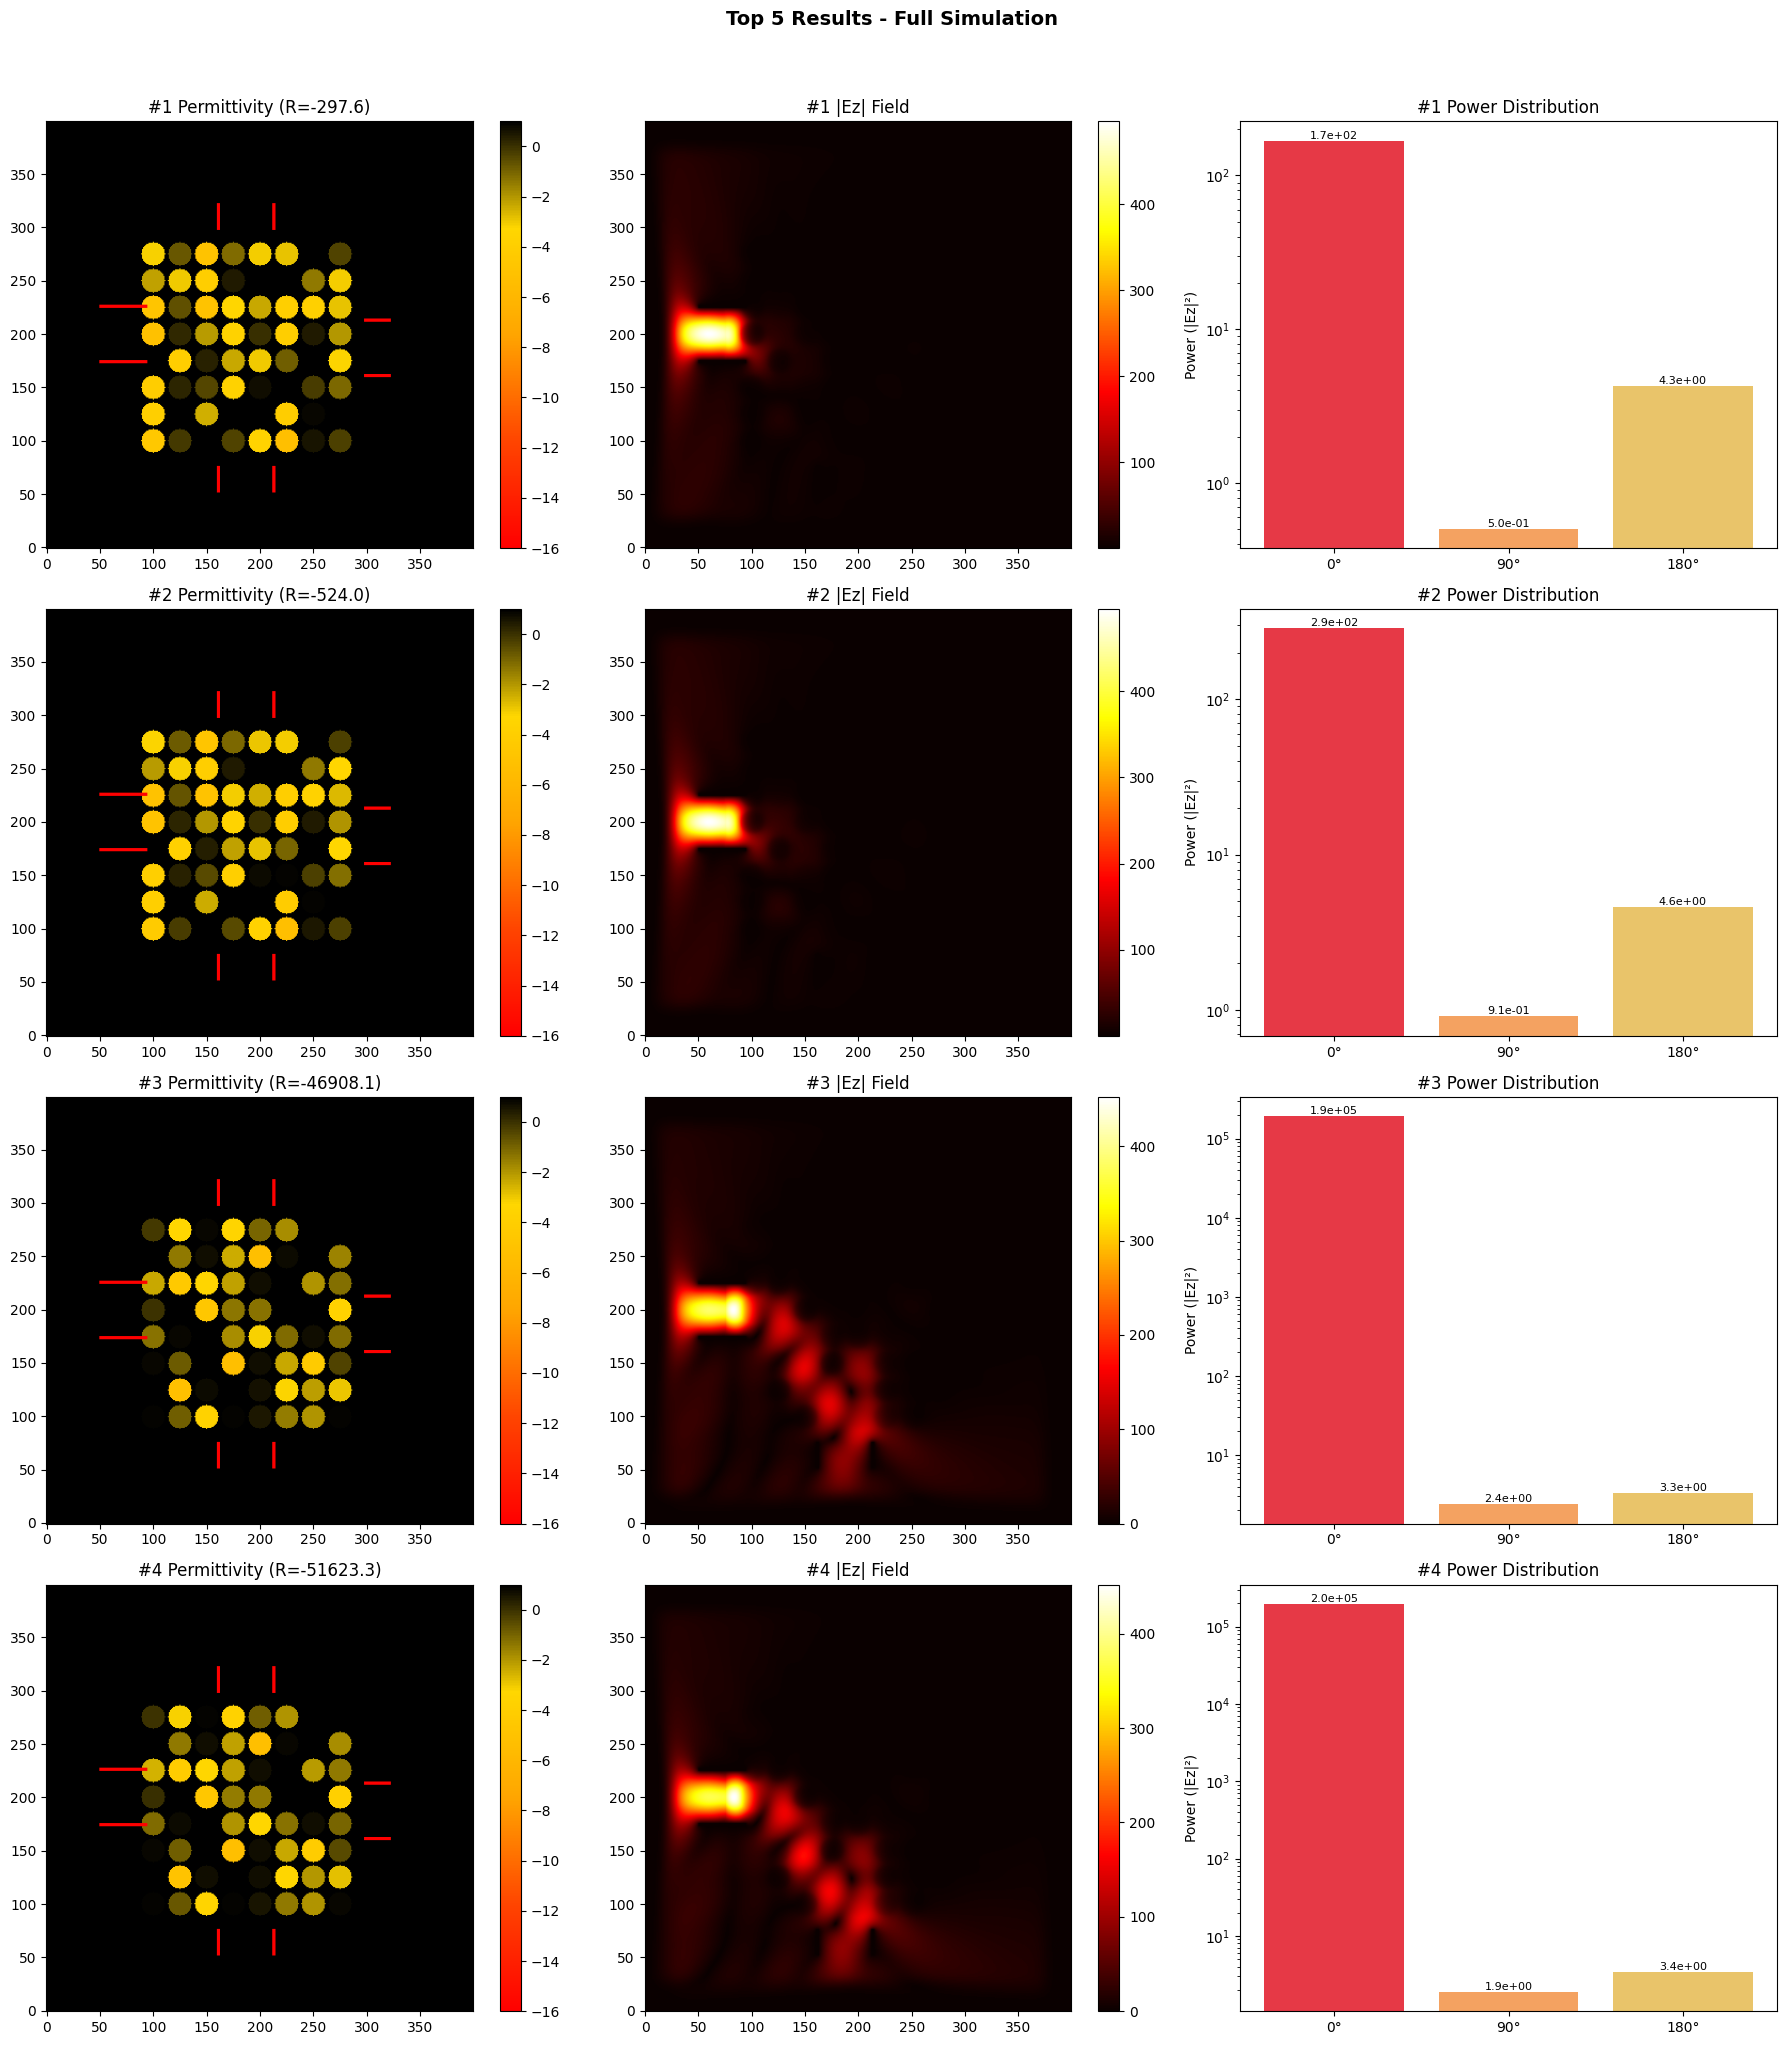

In [6]:
# Simulate and visualize top 5 results side by side
n_to_show = min(5, len(top_10))

if n_to_show > 0:
    fig, axes = plt.subplots(n_to_show, 3, figsize=(18, 5 * n_to_show))
    if n_to_show == 1:
        axes = axes.reshape(1, -1)
    
    for idx, result in enumerate(top_10[:n_to_show]):
        print(f"Simulating #{idx+1}...")
        eps_r, Ez, powers = simulate_from_rho(result['rho'], verbose=False)
        
        # Permittivity
        eps_display = np.clip(eps_r, -16, 1)
        im0 = axes[idx, 0].imshow(eps_display.T, origin='lower', cmap=EPS_CMAP, vmin=-16, vmax=1)
        axes[idx, 0].set_title(f'#{idx+1} Permittivity (R={result["reward"]:.1f})')
        plt.colorbar(im0, ax=axes[idx, 0])
        
        # Field
        im1 = axes[idx, 1].imshow(np.abs(Ez).T, origin='lower', cmap='hot')
        axes[idx, 1].set_title(f'#{idx+1} |Ez| Field')
        plt.colorbar(im1, ax=axes[idx, 1])
        
        # Power bar chart
        angles = list(powers.keys())
        power_values = list(powers.values())
        colors = ['#e63946', '#f4a261', '#e9c46a']  # Bottom, Forward, Top
        bars = axes[idx, 2].bar([f"{a}°" for a in angles], power_values, color=colors)
        axes[idx, 2].set_ylabel('Power (|Ez|²)')
        axes[idx, 2].set_title(f'#{idx+1} Power Distribution')
        axes[idx, 2].set_yscale('log')
        
        # Add value labels
        for bar, power in zip(bars, power_values):
            axes[idx, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                             f'{power:.1e}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Top 5 Results - Full Simulation', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No results to display.")

## Summary Statistics

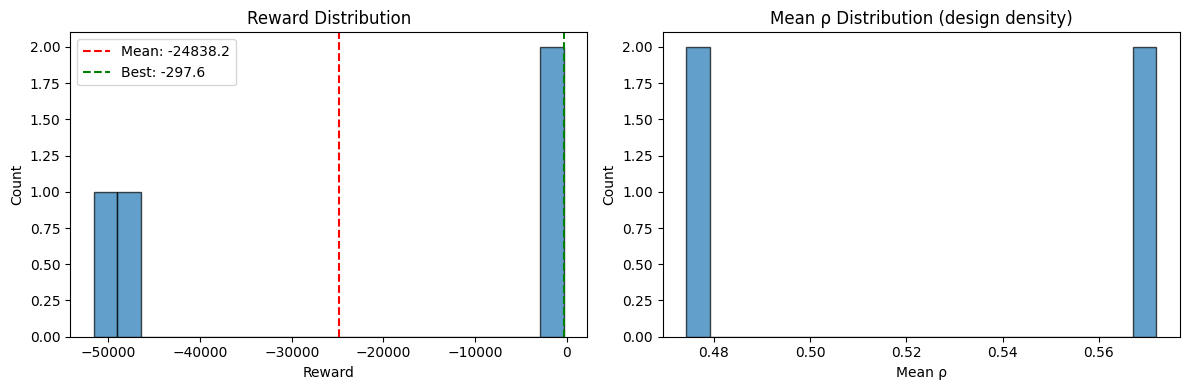


Summary:
  Total configurations: 4
  Best reward: -297.60
  Worst reward: -51623.32
  Mean reward: -24838.25


In [7]:
# Summary statistics
if len(all_results) > 0:
    rewards = [r['reward'] for r in all_results]
    rho_means = [r['rho_mean'] for r in all_results if r['rho_mean'] is not None]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Reward distribution
    axes[0].hist(rewards, bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(rewards), color='red', linestyle='--', label=f'Mean: {np.mean(rewards):.1f}')
    axes[0].axvline(np.max(rewards), color='green', linestyle='--', label=f'Best: {np.max(rewards):.1f}')
    axes[0].set_xlabel('Reward')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Reward Distribution')
    axes[0].legend()
    
    # Rho mean distribution
    if rho_means:
        axes[1].hist(rho_means, bins=20, edgecolor='black', alpha=0.7)
        axes[1].set_xlabel('Mean ρ')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Mean ρ Distribution (design density)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary:")
    print(f"  Total configurations: {len(all_results)}")
    print(f"  Best reward: {np.max(rewards):.2f}")
    print(f"  Worst reward: {np.min(rewards):.2f}")
    print(f"  Mean reward: {np.mean(rewards):.2f}")
else:
    print("No results to analyze.")